# LangGraph 기초 및 활용

## 1. langchain 패키지 설치
- openai api는 파이썬용 SDK 를 설치하거나 HTTP Client 를 사용하여 REST API 를 직접 호출하는 방식으로 사용할 수 있습니다.
- 프로그래밍 언어 선택에 제약이 있는 경우를 제외하면 대부분 파이썬 SDK 를 설치하여 사용합니다.

In [1]:
%%capture
!pip install langchain langgraph openai

## 2. Azure OpenAI 리소스 정보 설정
- openai API 를 호출하기 위해서는 API key 를 입력해야합니다.
- Azure OpenAI 의 경우, API key 뿐만 아니라 endpoint, deployment name 등이 추가로 필요합니다.
- 이 실습 환경에서는 Azure OpenAI 를 사용하기 위해 필요한 정보를 환경변수로 제공합니다.

In [2]:
#실습용 AOAI 환경변수 읽기
import os

AOAI_ENDPOINT=os.getenv("AOAI_ENDPOINT")
AOAI_API_KEY=os.getenv("AOAI_API_KEY")
AOAI_DEPLOY_GPT4O=os.getenv("AOAI_DEPLOY_GPT4O")
AOAI_DEPLOY_GPT4O_MINI=os.getenv("AOAI_DEPLOY_GPT4O_MINI")
AOAI_DEPLOY_EMBED_3_LARGE=os.getenv("AOAI_DEPLOY_EMBED_3_LARGE")
AOAI_DEPLOY_EMBED_3_SMALL=os.getenv("AOAI_DEPLOY_EMBED_3_SMALL")
AOAI_DEPLOY_EMBED_ADA=os.getenv("AOAI_DEPLOY_EMBED_ADA")

## 3. LangGraph 기본 구조

기본적으로 상태 그래프(State Graph) 컨셉으로 관리되며 State, Node, Edge 로 구성된다.
- 상태 (State) : 시스템의 현재 상태를 나타내는 데이터 구조입니다. 각 노드는 이 상태를 입력으로 받아 처리하며, 처리 결과에 따라 상태를 업데이트합니다.
- 노드 (Node) : 그래프를 구성하는 처리 단위로, 각 노드는 특정 작업을 수행합니다.
- 엣지 (Edge) : 노드 간의 연결을 나타내며, 데이터 흐름을 정의합니다.

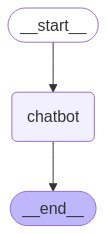

In [3]:
from langchain_openai import AzureChatOpenAI

llm = AzureChatOpenAI(
    azure_endpoint=AOAI_ENDPOINT,
    azure_deployment=AOAI_DEPLOY_GPT4O,
    api_version="2024-10-21",
    api_key=AOAI_API_KEY
)

from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]     # add_messages는 기존 메시지가 있으면 update하고 없으면 새로 추가한다.

graph_builder = StateGraph(State)


def chatbot(state: State):
    print(state["messages"])
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)
graph = graph_builder.compile()

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [4]:
for chunk in graph.stream(
    {"messages": [("human", "오늘 날씨 어때?")]}, stream_mode="values"
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

오늘 날씨 어때?
[HumanMessage(content='오늘 날씨 어때?', additional_kwargs={}, response_metadata={}, id='ef78f1d1-af4e-461f-98b5-b693f364ecd6')]
================================== Ai Message ==================================

죄송하지만, 실시간 정보를 제공할 수는 없습니다. 현재 지역의 정확한 날씨를 확인하려면 스마트폰의 날씨 앱이나 네이버/다음과 같은 포털 사이트를 참고하시기 바랍니다! 😊


## 4. LangGraph 기반 Tool Agent 구현
- 외부 API 연동을 위한 테스트 서버 http://52.141.29.94:8800/docs
- LLM 으로부터 Tool Message를 받으면 Tool Node를 실행하여 답변하는 에이전트

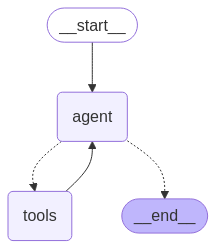

In [5]:
from langchain_core.messages import AIMessage
from langchain_core.tools import tool

from langgraph.prebuilt import ToolNode

import requests

@tool
def get_cafeteria_menu(day: str|None):
    """
    주어진 요일의 구내식당 메뉴를 조회하는 함수.
    day 가 None 일 경우 이번주 메뉴 조회

    :param day: 조회할 요일 (예: '월요일', '화요일' 등)
    :return: JSON 응답을 파이썬 딕셔너리로 변환하여 반환
    """
    url = "http://52.141.29.94:8800/cafeteria-menu"
    params = {"day": day}
    headers = {"accept": "application/json"}

    try:
        response = requests.get(url, headers=headers, params=params)
        response.raise_for_status()  # HTTP 오류 발생 시 예외 발생
        return response.json()  # JSON 응답을 파이썬 딕셔너리로 변환
    except requests.exceptions.RequestException as e:
        print(f"API 요청 중 오류 발생: {e}")
        return None
        
@tool
def get_schedule():
    """스케쥴 조회"""
    url = "http://52.141.29.94:8800/schedule"
    headers = {"accept": "application/json"}
    
    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status() 
        return response.json() 
    except requests.exceptions.RequestException as e:
        print(f"API 요청 중 오류 발생: {e}")
        return None


tools = [get_schedule, get_cafeteria_menu]
tool_node = ToolNode(tools)

model_with_tools = llm.bind_tools(tools)


from langgraph.graph import StateGraph, MessagesState, START, END


def should_continue(state: MessagesState):
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END


def call_model(state: MessagesState):
    messages = state["messages"]
    response = model_with_tools.invoke(messages)
    return {"messages": [response]}


workflow = StateGraph(MessagesState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "agent")
workflow.add_conditional_edges("agent", should_continue, ["tools", END])
workflow.add_edge("tools", "agent")

app = workflow.compile()

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [7]:
for chunk in app.stream(
    {"messages": [("human", "안녕?")]}, stream_mode="values"
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

안녕?
================================== Ai Message ==================================

안녕하세요! 😊 무엇을 도와드릴까요?


## 5. Memory
- 이전 상태를 기억하고 이전 상태를 바탕으로 다음 질의를 응답합니다.
- LangGraph에서는 다양한 형태의 MemorySaver를 제공합니다.
- 상태를 기억하는 단위는 thread_id 이며, 본 실습에서는 unique 값인 사번을 활용해보겠습니다.

In [11]:
from langgraph.checkpoint.memory import MemorySaver

checkpointer = MemorySaver()
app = workflow.compile(checkpointer=checkpointer)

config = {"configurable": {"thread_id": "11062"}}

for chunk in app.stream(
    {"messages": [("human", "이번 주 식당 메뉴 알려줘")]}, config=config, stream_mode="values"
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

이번 주 식당 메뉴 알려줘
================================== Ai Message ==================================
Tool Calls:
  get_cafeteria_menu (call_X13hXFcRCAeup0jaxyl9d8ti)
 Call ID: call_X13hXFcRCAeup0jaxyl9d8ti
  Args:
    day: None
================================= Tool Message =================================
Name: get_cafeteria_menu

{"월요일": "김치찌개, 불고기, 계란말이", "화요일": "된장찌개, 제육볶음, 잡채", "수요일": "순두부찌개, 닭갈비, 감자전", "목요일": "미역국, 돈까스, 샐러드", "금요일": "떡국, 생선구이, 나물무침"}
================================== Ai Message ==================================

이번 주 식당 메뉴는 다음과 같습니다:

- **월요일**: 김치찌개, 불고기, 계란말이
- **화요일**: 된장찌개, 제육볶음, 잡채
- **수요일**: 순두부찌개, 닭갈비, 감자전
- **목요일**: 미역국, 돈까스, 샐러드
- **금요일**: 떡국, 생선구이, 나물무침

맛있게 드세요! 😊


## 6. Multi Agent
- 에이전트에게 제공해야할 지침이 늘어나거나 Tool의 수가 늘어날수록 성능은 떨어집니다.
- 에이전트 별로 전문적인 지식과 Tool을 주고, Supervisor가 업무를 부여함으로써 성능을 올릴 수 있습니다.
- Command 는 24년 12월에 발표한 Multi Agent 도구로 edge 정의 없이도 다음 노드로 이동할 수 있게 해줍니다.
  다음 문서를 참고해주세요. (https://blog.langchain.dev/command-a-new-tool-for-multi-agent-architectures-in-langgraph/)

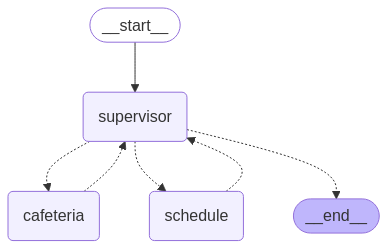

In [12]:
from typing import Literal
from typing_extensions import TypedDict

from langgraph.graph import MessagesState, END
from langgraph.types import Command
from langchain_openai import AzureChatOpenAI
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode

from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent


members = ["cafeteria", "schedule"]
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = members + ["FINISH"]

system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)


class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal[*options]

class State(MessagesState):
    next: str


def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    if goto == "FINISH":
        goto = END

    return Command(goto=goto, update={"next": goto})


cafeteria_agent = create_react_agent(
    llm, tools=[get_cafeteria_menu], prompt="당신은 구내식당을 관리하는 영양사입니다. 사용자에게 이번 주의 식단을 알려줄 수 있습니다."
)

def cafeteria_node(state: State) -> Command[Literal["supervisor"]]:
    result = cafeteria_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="cafeteria")
            ]
        },
        goto="supervisor",
    )

schedule_agent = create_react_agent(
    llm, tools=[get_schedule], prompt="당신은 사용자의 일정을 관리하는 비서입니다. 사용자에게 현재 남아있는 일정을 안내합니다."
)

def schedule_node(state: State) -> Command[Literal["supervisor"]]:
    result = schedule_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="schedule")
            ]
        },
        goto="supervisor",
    )

builder = StateGraph(State)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("cafeteria", cafeteria_node)
builder.add_node("schedule", schedule_node)
graph = builder.compile()

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass


In [13]:
for s in graph.stream(
    {"messages": [("user", "월요일 식단이 궁금해")]}, subgraphs=True
):
    print(s)
    print("----")

((), {'supervisor': {'next': 'cafeteria'}})
----
(('cafeteria:37647f69-89c2-6de4-54cc-bd5573cfbe31',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_uJtRgQ0N5DwAMPLhFp2fxJLf', 'function': {'arguments': '{"day":"월요일"}', 'name': 'get_cafeteria_menu'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 148, 'total_tokens': 167, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_b705f0c291', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 